# AD Modelling Pipeline

Put all the different models together to assemble the adapted whole-brain modelling pipeline

In [2]:
import pickle
import numpy as np
import pandas as pd
from whobpyt.datatypes import par
from whobpyt.models.RWWABT import RNNRWWABT, ParamsRWWABT
from whobpyt.optimization.custom_cost_RWW import CostsRWW
from whobpyt.run import Model_fitting
import torch

import matplotlib.pyplot as plt 
import seaborn as sns

In [6]:
node_size = 100
TPperWindow = 20
step_size = 0.1
tr = 0.75
repeat_size = 5

num_windows = 9    # arbitrary - controls length of simulations

In [3]:
# Load the models from the file
with open('pipeline_models/cn_abt_model.pkl', 'rb') as f:
    cn_model = pickle.load(f)

with open('pipeline_models/MCI_abt_model.pkl', 'rb') as f:
    mci_model = pickle.load(f)

with open('pipeline_models/AD_abt_model.pkl', 'rb') as f:
    ad_model = pickle.load(f)

whole_brain_models = [cn_model, mci_model, ad_model]

with open('pipeline_models/gbregressor_ventricular_icv.pkl', 'rb') as f:
    predictor = pickle.load(f)

/Users/dyutichakraborty/Documents/ad_modelling_fyp/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DummyRegressor from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/dyutichakraborty/Documents/ad_modelling_fyp/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/dyutichakraborty/Documents/ad_modelling_fyp/venv/lib/python3.11/site-packages/sklearn/base.py:376:

In [8]:
ts_sim, fc_sim = cn_model.simulate(u =0, num_windows=num_windows, base_window_num=20)

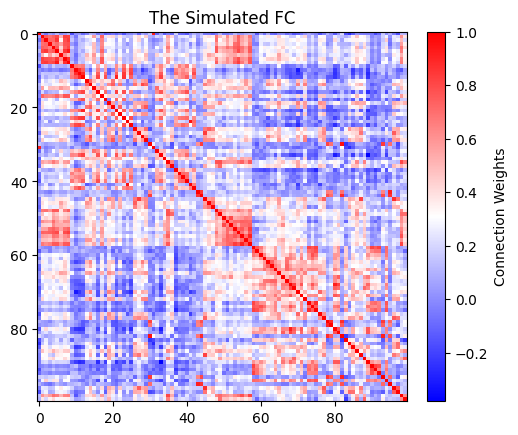

In [9]:
plt.imshow(fc_sim, cmap='bwr')
plt.title('The Simulated FC')
plt.colorbar(fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

In [10]:
def compute_fc_lower_triangle(fc, node_size=100):
    """
    Extract the lower triangle from a functional connectivity matrix.
    
    Pre-processing step required to make the simulated FC matrices the correct format
    for the predictor model
    """
    mask_e = np.tril_indices(node_size, -1)
    lower_triangle = fc[mask_e]
    
    return lower_triangle

In [11]:
lower_triangle_fc = compute_fc_lower_triangle(fc_sim)
print(len(lower_triangle_fc))
v = predictor.predict([lower_triangle_fc])

# get the predicted ventricular volume score
v[0]

4950


0.02338033181711399

# Whole-Brain Modelling Experiments

## Predict Ventricular Volume for each Patient Group Model

0
Group: CN
Group: MCI
Group: AD
1
Group: CN
Group: MCI
Group: AD
2
Group: CN
Group: MCI
Group: AD
3
Group: CN
Group: MCI
Group: AD
4
Group: CN
Group: MCI
Group: AD
5
Group: CN
Group: MCI
Group: AD
6
Group: CN
Group: MCI
Group: AD
7
Group: CN
Group: MCI
Group: AD
8
Group: CN
Group: MCI
Group: AD
9
Group: CN
Group: MCI
Group: AD
10
Group: CN
Group: MCI
Group: AD
11
Group: CN
Group: MCI
Group: AD
12
Group: CN
Group: MCI
Group: AD
13
Group: CN
Group: MCI
Group: AD
14
Group: CN
Group: MCI
Group: AD
15
Group: CN
Group: MCI
Group: AD
16
Group: CN
Group: MCI
Group: AD
17
Group: CN
Group: MCI
Group: AD
18
Group: CN
Group: MCI
Group: AD
19
Group: CN
Group: MCI
Group: AD
20
Group: CN
Group: MCI
Group: AD
21
Group: CN
Group: MCI
Group: AD
22
Group: CN
Group: MCI
Group: AD
23
Group: CN
Group: MCI
Group: AD
24
Group: CN
Group: MCI
Group: AD


/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/ipykernel_72676/2508761647.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ventricular_icv, labels=groups)


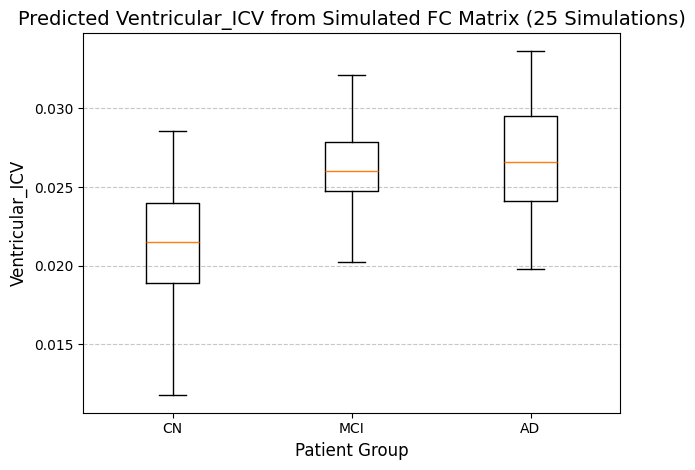

In [110]:
groups = ['CN', 'MCI', 'AD']
ventricular_icv = [[], [], []]

for i in range(25):
    print(i)
    for i in range(len(groups)):
        print(f'Group: {groups[i]}')
        model = whole_brain_models[i]

        _, fc = model.simulate(u =0, num_windows=num_windows, base_window_num=20)
        lower_triangle_fc = compute_fc_lower_triangle(fc)
        v = predictor.predict([lower_triangle_fc])
        ventricular_icv[i].append(v[0])

# plt.figure(figsize=(10, 8))
plt.boxplot(ventricular_icv, labels=groups)

plt.title('Predicted Ventricular_ICV from Simulated FC Matrix (25 Simulations)', fontsize=14)
plt.xlabel('Patient Group', fontsize=12)
plt.ylabel('Ventricular_ICV', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [111]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

value_dict = pd.DataFrame({
    'CN' : ventricular_icv[0],
    'MCI' : ventricular_icv[1],
    'AD' : ventricular_icv[2],
})

pairs = [(groups[i], groups[j]) for i in range(len(groups)) for j in range(i + 1, len(groups))]

# Perform t-tests
p_values = []
for pair in pairs:
    combo1, combo2 = pair
    t_stat, p_val = ttest_ind(value_dict[combo1], value_dict[combo2])
    p_values.append(p_val)

# Adjust p-values for multiple comparisons using FDR
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

for i, pair in enumerate(pairs):
    combo1, combo2 = pair
    print(f"T-test between {combo1} and {combo2}:")
    print(f"  p-value (uncorrected): {p_values[i]:.5}")
    print(f"  p-value (FDR corrected): {pvals_corrected[i]:.5f}")
    print(f"  Significant after FDR correction: {'Yes' if reject[i] else 'No'}\n")

T-test between CN and MCI:
  p-value (uncorrected): 1.2099e-05
  p-value (FDR corrected): 0.00002
  Significant after FDR correction: Yes

T-test between CN and AD:
  p-value (uncorrected): 5.0628e-06
  p-value (FDR corrected): 0.00002
  Significant after FDR correction: Yes

T-test between MCI and AD:
  p-value (uncorrected): 0.54462
  p-value (FDR corrected): 0.54462
  Significant after FDR correction: No



/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/ipykernel_72676/3098716045.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ventricular_icv, labels=groups)


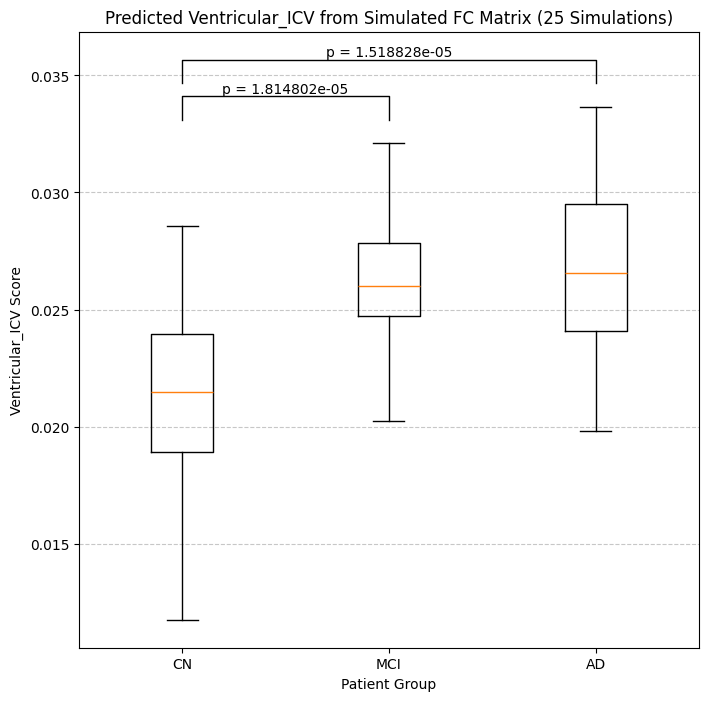

In [117]:
plt.figure(figsize=(8, 8))
plt.boxplot(ventricular_icv, labels=groups)

plt.title('Predicted Ventricular_ICV from Simulated FC Matrix (25 Simulations)')
plt.xlabel('Patient Group')
plt.ylabel('Ventricular_ICV Score')


plt.grid(axis='y', linestyle='--', alpha=0.7)

h_extra = 0
for i, pair in enumerate(pairs):
    if i == 2:
        break
    combo1, combo2 = pair
    x1, x2 = groups.index(combo1) + 1, groups.index(combo2) + 1 
    y, h, col = value_dict[[combo1, combo2]].values.max() + 0.001, 0.001, 'k'
    y += h_extra
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c=col)
    plt.text((x1 + x2) * 0.5, y + h, "p = {:e}".format(pvals_corrected[i]), ha='center', va='bottom', color=col)

# plt.savefig('predict_score_patient_group.png')
plt.show()

## Vary CN + AD Parameters and fitted SC Matrices

In [119]:
cn_fitted_sc = cn_model.model.sc_fitted.detach().numpy()

cn_fitted_bAB_E = cn_model.trainingStats.fit_params['bAB_E'][-1]
cn_fitted_sAB_E = cn_model.trainingStats.fit_params['sAB_E'][-1]
cn_fitted_bt_E = cn_model.trainingStats.fit_params['bt_E'][-1]
cn_fitted_st_E = cn_model.trainingStats.fit_params['st_E'][-1]
cn_fitted_bAB_I = cn_model.trainingStats.fit_params['bAB_I'][-1]
cn_fitted_sAB_I = cn_model.trainingStats.fit_params['sAB_I'][-1]

In [120]:
ad_fitted_sc = ad_model.model.sc_fitted.detach().numpy()

ad_fitted_bAB_E = ad_model.trainingStats.fit_params['bAB_E'][-1]
ad_fitted_sAB_E = ad_model.trainingStats.fit_params['sAB_E'][-1]
ad_fitted_bt_E = ad_model.trainingStats.fit_params['bt_E'][-1]
ad_fitted_st_E = ad_model.trainingStats.fit_params['st_E'][-1]
ad_fitted_bAB_I = ad_model.trainingStats.fit_params['bAB_I'][-1]
ad_fitted_sAB_I = ad_model.trainingStats.fit_params['sAB_I'][-1]

In [121]:
def define_model(fitted_sc, pgroup, fitted_bAB_E, fitted_sAB_E, fitted_bt_E, fitted_st_E, fitted_bAB_I, fitted_sAB_I):
    params = ParamsRWWABT(bAB_E=par(val=fitted_bAB_E, fit_par=True), sAB_E=par(val=fitted_sAB_E, fit_par=True), bt_E=par(val=fitted_bt_E, fit_par=True),
                          st_E=par(val=fitted_st_E, fit_par=True), bAB_I=par(val=fitted_bAB_I, fit_par=True), sAB_I=par(val=fitted_sAB_I, fit_par=True))

    abeta_file = np.genfromtxt(f'../data/avg_scans/AB_{pgroup}.csv', delimiter=",")
    abeta = torch.tensor(abeta_file, dtype=torch.float32)

    tau_file = np.genfromtxt(f'../data/avg_scans/TAU_{pgroup}.csv', delimiter=",")
    tau = torch.tensor(tau_file, dtype=torch.float32)

    model = RNNRWWABT(node_size, TPperWindow, step_size, repeat_size, tr, fitted_sc, abeta, tau, True, params)

    ObjFun = CostsRWW(model)

    F = Model_fitting(model, ObjFun)
    
    return F

def simulate_FC(F):
    _, fc_sim = F.simulate(u =0, num_windows=num_windows, base_window_num=20)
    return fc_sim

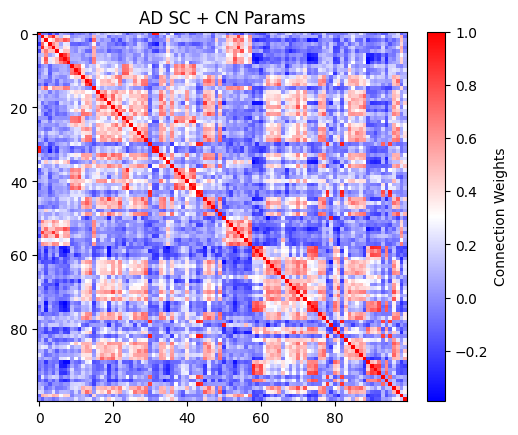

In [38]:
# Try varying the SC and params combo

model = define_model(ad_fitted_sc, 'CN', cn_fitted_bAB_E, cn_fitted_sAB_E, cn_fitted_bt_E, cn_fitted_st_E, cn_fitted_bAB_I, cn_fitted_sAB_I)
fc_sim = simulate_FC(model)

plt.imshow(fc_sim, cmap='bwr')
plt.title('AD SC + CN Params')
plt.colorbar(fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

In [122]:
# define all parameter combinations
ad_sc_ad_params = {
    'fitted_sc': ad_fitted_sc,
    'pgroup': 'AD',  
    'fitted_bAB_E': ad_fitted_bAB_E, 
    'fitted_sAB_E': ad_fitted_sAB_E, 
    'fitted_bt_E': ad_fitted_bt_E, 
    'fitted_st_E': ad_fitted_st_E, 
    'fitted_bAB_I': ad_fitted_bAB_I, 
    'fitted_sAB_I': ad_fitted_sAB_I
}

ad_sc_cn_params = {
    'fitted_sc': ad_fitted_sc, 
    'pgroup': 'CN', 
    'fitted_bAB_E': cn_fitted_bAB_E, 
    'fitted_sAB_E': cn_fitted_sAB_E, 
    'fitted_bt_E': cn_fitted_bt_E, 
    'fitted_st_E': cn_fitted_st_E, 
    'fitted_bAB_I': cn_fitted_bAB_I, 
    'fitted_sAB_I': cn_fitted_sAB_I
}

cn_sc_ad_params = {
    'fitted_sc': cn_fitted_sc, 
    'pgroup': 'AD', 
    'fitted_bAB_E': ad_fitted_bAB_E, 
    'fitted_sAB_E': ad_fitted_sAB_E, 
    'fitted_bt_E': ad_fitted_bt_E, 
    'fitted_st_E': ad_fitted_st_E, 
    'fitted_bAB_I': ad_fitted_bAB_I, 
    'fitted_sAB_I': ad_fitted_sAB_I
}

cn_sc_cn_params = {
    'fitted_sc': cn_fitted_sc,
    'pgroup': 'CN',  
    'fitted_bAB_E': cn_fitted_bAB_E, 
    'fitted_sAB_E': cn_fitted_sAB_E, 
    'fitted_bt_E': cn_fitted_bt_E, 
    'fitted_st_E': cn_fitted_st_E, 
    'fitted_bAB_I': cn_fitted_bAB_I, 
    'fitted_sAB_I': cn_fitted_sAB_I
}

In [123]:
groups = ['AD SC + AD Params', 'AD SC + CN Params', 'CN SC + AD Params', 'CN SC + CN Params']
param_sets = [ad_sc_ad_params, ad_sc_cn_params, cn_sc_ad_params, cn_sc_cn_params]

ventricular_icv = []

for i in range(len(groups)):
    print(f'Trial: {groups[i]}')
    model = define_model(**param_sets[i])
    simulations = []
    for i in range(25):
        fc = simulate_FC(model)
        lower_triangle_fc = compute_fc_lower_triangle(fc)
        simulations.append(lower_triangle_fc)
        
    v = predictor.predict(simulations)
    ventricular_icv.append(v)
    

Trial: AD SC + AD Params
Trial: AD SC + CN Params
Trial: CN SC + AD Params
Trial: CN SC + CN Params


/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/ipykernel_72676/2251589116.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ventricular_icv, labels=groups)


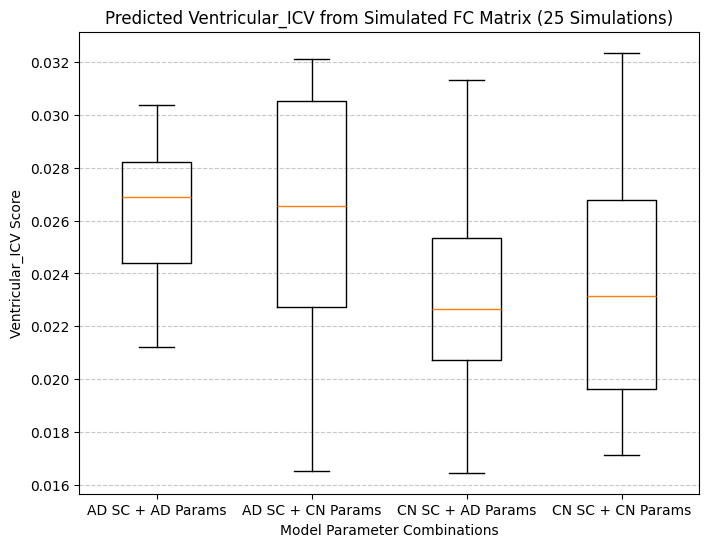

In [130]:
plt.figure(figsize=(8, 6))
plt.boxplot(ventricular_icv, labels=groups)

plt.title('Predicted Ventricular_ICV from Simulated FC Matrix (25 Simulations)')
plt.xlabel('Model Parameter Combinations')
plt.ylabel('Ventricular_ICV Score')


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('sc_and_param_combos_predicted_scores_2.png')
plt.show()

### Conducting FRD-correcte t-tests between plots

In [125]:
value_dict = pd.DataFrame({
    'AD SC + AD Params' : ventricular_icv[0],
    'AD SC + CN Params' : ventricular_icv[1],
    'CN SC + AD Params' : ventricular_icv[2],
    'CN SC + CN Params' : ventricular_icv[3]
})

pairs = [(groups[i], groups[j]) for i in range(len(groups)) for j in range(i + 1, len(groups))]

In [126]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Perform t-tests
p_values = []
for pair in pairs:
    combo1, combo2 = pair
    t_stat, p_val = ttest_ind(value_dict[combo1], value_dict[combo2])
    p_values.append(p_val)

# Adjust p-values for multiple comparisons using FDR
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

for i, pair in enumerate(pairs):
    combo1, combo2 = pair
    print(f"T-test between {combo1} and {combo2}:")
    print(f"  p-value (uncorrected): {p_values[i]:.6}")
    print(f"  p-value (FDR corrected): {pvals_corrected[i]:.6f}")
    print(f"  Significant after FDR correction: {'Yes' if reject[i] else 'No'}\n")

T-test between AD SC + AD Params and AD SC + CN Params:
  p-value (uncorrected): 0.974824
  p-value (FDR corrected): 0.974824
  Significant after FDR correction: No

T-test between AD SC + AD Params and CN SC + AD Params:
  p-value (uncorrected): 0.000504337
  p-value (FDR corrected): 0.003026
  Significant after FDR correction: Yes

T-test between AD SC + AD Params and CN SC + CN Params:
  p-value (uncorrected): 0.00159082
  p-value (FDR corrected): 0.004772
  Significant after FDR correction: Yes

T-test between AD SC + CN Params and CN SC + AD Params:
  p-value (uncorrected): 0.00419516
  p-value (FDR corrected): 0.008390
  Significant after FDR correction: Yes

T-test between AD SC + CN Params and CN SC + CN Params:
  p-value (uncorrected): 0.0085155
  p-value (FDR corrected): 0.012773
  Significant after FDR correction: Yes

T-test between CN SC + AD Params and CN SC + CN Params:
  p-value (uncorrected): 0.869486
  p-value (FDR corrected): 0.974824
  Significant after FDR correcti

/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/ipykernel_72676/288829173.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ventricular_icv, labels=groups)


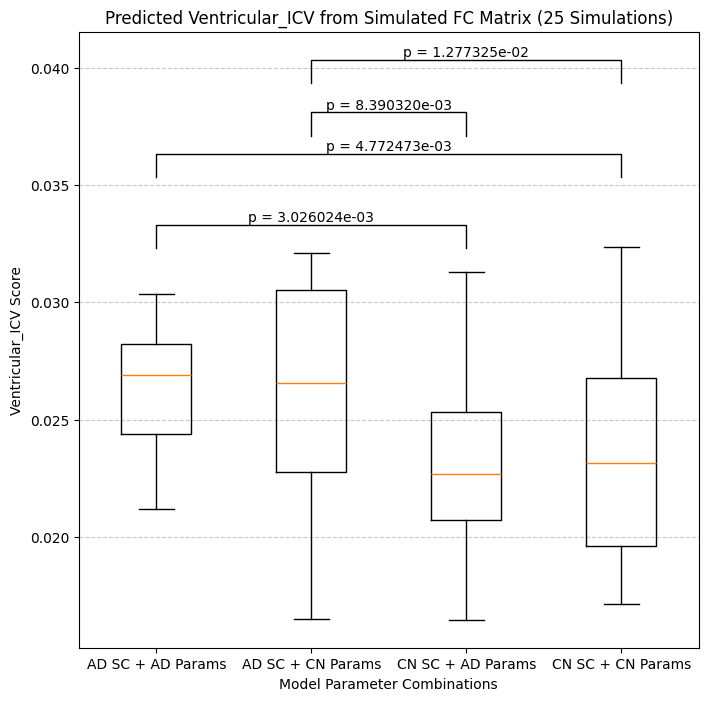

In [129]:
plt.figure(figsize=(8, 8))
plt.boxplot(ventricular_icv, labels=groups)

plt.title('Predicted Ventricular_ICV from Simulated FC Matrix (25 Simulations)')
plt.xlabel('Model Parameter Combinations')
plt.ylabel('Ventricular_ICV Score')


plt.grid(axis='y', linestyle='--', alpha=0.7)

h_extra = 0
for i, pair in enumerate(pairs):
    if i == 0 or i == 5:
        pass
    else:
        combo1, combo2 = pair
        x1, x2 = groups.index(combo1) + 1, groups.index(combo2) + 1 
        y, h, col = value_dict[[combo1, combo2]].values.max() + 0.001, 0.001, 'k'
        y += h_extra
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c=col)
        plt.text((x1 + x2) * 0.5, y + h, "p = {:e}".format(pvals_corrected[i]), ha='center', va='bottom', color=col)

        h_extra += 0.002

plt.savefig('sc_and_param_combos_predicted_scores_t_tested_2.png')
plt.show()


In [91]:
# np.savetxt('sc_and_param_combos_predicted_scores.txt', ventricular_icv)

## Ventricular prediction from varying sAB_E

In [188]:
sAB_E_data = np.loadtxt('../data/prediction_res/trialled_sAB_I_CN_sc.txt')
predicted_ventr = np.loadtxt('../data/prediction_res/predicted_ventr_icv_sAB_I_CN_sc.txt')

Pearsons R:  0.05462274384172218
P Value:  0.4423600303026143


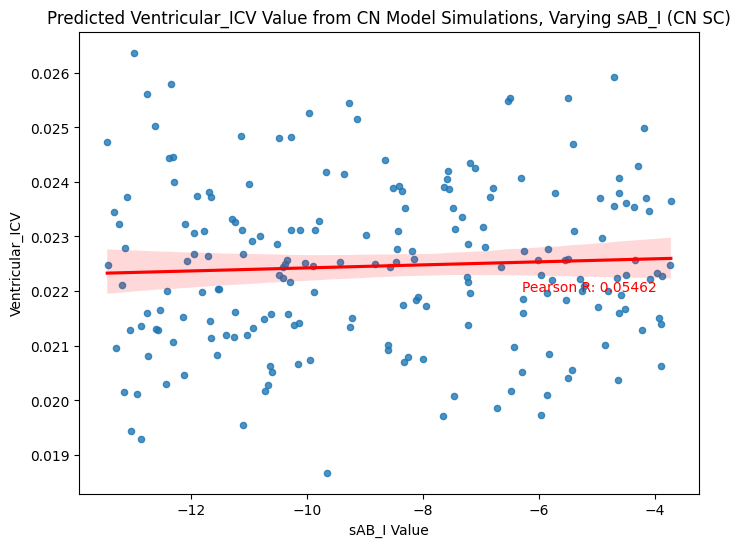

In [189]:
from scipy.stats import pearsonr

plt.figure(figsize=(8,6))
p = sns.regplot(x=sAB_E_data, y=predicted_ventr, line_kws={'color':'red'}, scatter_kws={'s':20})
plt.title('Predicted Ventricular_ICV Value from CN Model Simulations, Varying sAB_I (CN SC)')
plt.xlabel('sAB_I Value')
plt.ylabel('Ventricular_ICV')

corr_coef, p_value = pearsonr(sAB_E_data, predicted_ventr)

plt.text(-6.3, 0.022, f"Pearson R: {corr_coef:.5f}", color='red')
print('Pearsons R: ', corr_coef)
print('P Value: ', p_value)

# plt.savefig('../data/prediction_res/predicted_ventr_icv_sAB_I_CN_sc_plot.png')
plt.show()